In [1]:
%cd ..

d:\github\ripple_heterogeneity\python


In [2]:
import pandas as pd
import numpy as np 
import glob
import matplotlib.pyplot as plt
import matplotlib

import hdf5storage
import h5py
import scipy.io as sio

import sys,os
import seaborn as sns

import functions,loading

import nelpy as nel  # main nelpy imports
import nelpy.plotting as npl  # optional plotting import

import math
from tqdm import tqdm
from scipy.ndimage import gaussian_filter1d

import multiprocessing
from joblib import Parallel, delayed
        

C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\plotting\decoding.py:9: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.


In [3]:
tex_fonts = {
#     # Use LaTeX to write all text
#     "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "svg.fonttype": 'none'
}
plt.style.use('seaborn-paper')
# plt.style.use('dark_background')

plt.rcParams.update(tex_fonts)

# plt.rcParams['svg.fonttype'] = 'none'

%config InlineBackend.figure_format = 'retina'

fig_save_path = 'G:/My Drive/post_doc/ripple_diversity/project_log'

In [4]:
import warnings
warnings.filterwarnings("ignore")

def load_basic_data(basepath):
    nChannels, fs, fs_dat, shank_to_channel = functions.loadXML(basepath)
    ripples = loading.load_ripples_events(basepath)
    cell_metrics,data = loading.load_cell_metrics(basepath)
    return cell_metrics,data,ripples,fs_dat
    
def main_analysis(st_rip,ripple_epochs,cell_metrics,ripples):
    n_deep = np.zeros([3,ripple_epochs.n_intervals])
    n_sup = np.zeros_like(n_deep)
    n_deep_whole_rip = np.zeros([1,ripple_epochs.n_intervals])
    n_sup_whole_rip = np.zeros_like(n_deep_whole_rip)

    for rip_i in range(ripple_epochs.n_intervals):

        active = [unit.shape[0]>0 for unit in st_rip[rip_i].data]
        n_deep_whole_rip[0,rip_i] = sum(cell_metrics.deepSuperficial[active] == "Deep")
        n_sup_whole_rip[0,rip_i] = sum(cell_metrics.deepSuperficial[active] == "Superficial")

        ts = np.linspace(ripple_epochs[rip_i].starts,ripple_epochs[rip_i].stops,4)
        within_ripple_epochs = nel.EpochArray(np.array([[ts[0],ts[1]],[ts[1],ts[2]],[ts[2],ts[3]]]))

        try:
            st_rip_within_ripple_epochs = st_rip[rip_i][within_ripple_epochs]
            for rip_inter in range(3):
                active = [unit.shape[0]>0 for unit in st_rip_within_ripple_epochs[rip_inter].data]

                n_deep[rip_inter,rip_i] = sum(cell_metrics.loc[active,'deepSuperficial'] == "Deep")
                n_sup[rip_inter,rip_i] = sum(cell_metrics.loc[active,'deepSuperficial'] == "Superficial")

                # n_deep[rip_inter,rip_i] = sum(cell_metrics.deepSuperficial[active] == "Deep")
                # n_sup[rip_inter,rip_i] = sum(cell_metrics.deepSuperficial[active] == "Superficial")
        except:
            print("failed...")
            print(st_rip_within_ripple_epochs[rip_inter].data)
            return pd.DataFrame()

    # normalize by n units
    n_deep = n_deep/sum(cell_metrics.deepSuperficial == "Deep")
    n_sup = n_sup/sum(cell_metrics.deepSuperficial == "Superficial")
    n_deep_whole_rip = n_deep_whole_rip/sum(cell_metrics.deepSuperficial == "Deep")
    n_sup_whole_rip = n_sup_whole_rip/sum(cell_metrics.deepSuperficial == "Superficial")

    # np.median(n_sup,axis=1)
    # np.median(n_deep,axis=1)
    
    ripples['deep whole'] = n_deep_whole_rip[0,:]
    ripples['sup whole'] = n_sup_whole_rip[0,:]
    ripples['deep start'] = n_deep[0,:]
    ripples['deep middle'] = n_deep[1,:]
    ripples['deep end'] = n_deep[2,:]
    ripples['sup start'] = n_sup[0,:]
    ripples['sup middle'] = n_sup[1,:]
    ripples['sup end'] = n_sup[2,:]

    return ripples

def session_loop(basepath,save_path):

    save_file = os.path.join(save_path,basepath.replace(os.sep, "_").replace(":", "_")  + '.csv')
    if os.path.exists(save_file):
        return

    cell_metrics,data,ripples,fs_dat = load_basic_data(basepath)

    restrict_idx = ((cell_metrics.putativeCellType == "Pyramidal Cell") &
                        ((cell_metrics.brainRegion=="CA1") |
                        (cell_metrics.brainRegion=="rCA1") |
                        (cell_metrics.brainRegion=="lCA1")))

    cell_metrics = cell_metrics[restrict_idx]

    if len(cell_metrics.UID) == 0:
        return

    ripple_epochs = nel.EpochArray([np.array([ripples.start,ripples.stop]).T])
    st = nel.SpikeTrainArray(timestamps=np.array(data['spikes'],dtype=object)[restrict_idx], fs=fs_dat)
    st_rip = st[ripple_epochs]

    ripples_results = main_analysis(st_rip,ripple_epochs,cell_metrics,ripples)

    ripples_results.to_csv(save_file)

def ripple_seg_run(df,save_path,parallel=True):
    # find sessions to run
    basepaths = pd.unique(df.basepath)

    if parallel:
        num_cores = multiprocessing.cpu_count()         
        processed_list = Parallel(n_jobs=num_cores)(delayed(session_loop)(basepath,save_path) for basepath in basepaths)
    else:    
        for basepath in basepaths:
            print(basepath)
            session_loop(basepath,save_path)

In [5]:
df = pd.read_csv(r'D:\projects\ripple_heterogeneity\sessions.csv')
save_path = r'D:\projects\ripple_heterogeneity\ripple_segments'
ripple_seg_run(df,save_path,parallel=True)

In [19]:
def load_in_everything(save_path):
    
    sessions = glob.glob(save_path + os.sep + '*.csv')
    
    results = pd.DataFrame()
    
    for session in sessions:
        df1 = pd.read_csv(session)
        # df1['basename'] = os.path.basename(session).replace('.csv', "")
        results = results.append(df1,ignore_index=True)
    return results

results = load_in_everything(save_path)
results

Unnamed: 0       start        stop       peaks   amplitude  duration  \
0               0      6.6664      6.7376      6.7344  148.142071    0.0712   
1               1     10.7232     10.7840     10.7536  252.530669    0.0608   
2               2     11.6744     11.7160     11.6920  100.563164    0.0416   
3               3     14.0488     14.1016     14.0648  403.632814    0.0528   
4               4     14.1976     14.2472     14.2256  245.586833    0.0496   
...           ...         ...         ...         ...         ...       ...   
962298       2110  11510.4864  11510.5456  11510.5056  518.043952    0.0592   
962299       2111  11511.5368  11511.6464  11511.6296  545.909138    0.1096   
962300       2112  11513.3240  11513.3776  11513.3400  143.808119    0.0536   
962301       2113  11515.4888  11515.5544  11515.5384  410.486532    0.0656   
962302       2114  11515.6632  11515.7080  11515.7040  543.189134    0.0448   

         frequency  detectorName  ripple_channel  event_spk_thres  ...  \
0       101.977713  bz_DetectSWR           170.0              0.0  ...   
1       117.171642  bz_DetectSWR           170.0              0.0  ...   
2       180.128884  bz_DetectSWR           170.0              0.0  ...   
3       127.209763  bz_DetectSWR           170.0              0.0  ...   
4       121.396806  bz_DetectSWR           170.0              0.0  ...   
...            ...           ...             ...              ...  ...   
962298  144.774536  bz_DetectSWR            12.0              1.0  ...   
962299  200.051056  bz_DetectSWR            12.0              1.0  ...   
962300   96.977666  bz_DetectSWR            12.0              1.0  ...   
962301  187.629415  bz_DetectSWR            12.0              1.0  ...   
962302  152.930030  bz_DetectSWR            12.0              1.0  ...   

       basename animal deep whole  sup whole  deep start  deep middle  \
0          day1    AB1   0.270833   0.100000    0.062500     0.125000   
1          day1    AB1   0.375000   0.000000    0.229167     0.250000   
2          day1    AB1   0.125000   0.200000    0.083333     0.041667   
3          day1    AB1   0.229167   0.200000    0.145833     0.041667   
4          day1    AB1   0.250000   0.300000    0.125000     0.104167   
...         ...    ...        ...        ...         ...          ...   
962298     day5   OR23   0.136842   0.000000    0.073684     0.073684   
962299     day5   OR23   0.200000   0.166667    0.115789     0.105263   
962300     day5   OR23   0.105263   0.333333    0.010526     0.073684   
962301     day5   OR23   0.147368   0.166667    0.094737     0.052632   
962302     day5   OR23   0.157895   0.000000    0.052632     0.052632   

        deep end  sup start  sup middle   sup end  
0       0.125000   0.000000    0.100000  0.100000  
1       0.250000   0.000000    0.000000  0.000000  
2       0.041667   0.100000    0.100000  0.100000  
3       0.041667   0.200000    0.100000  0.100000  
4       0.104167   0.100000    0.300000  0.300000  
...          ...        ...         ...       ...  
962298  0.073684   0.000000    0.000000  0.000000  
962299  0.105263   0.166667    0.000000  0.000000  
962300  0.073684   0.166667    0.166667  0.166667  
962301  0.052632   0.166667    0.000000  0.000000  
962302  0.052632   0.000000    0.000000  0.000000  

[962303 rows x 21 columns]

In [73]:
# results.basepath.unique()

df_grosmark = results.loc[results['basepath'].str.contains("GrosmarkAD", case=False)]
df_grosmark

Unnamed: 0       start        stop       peaks   amplitude  duration  \
377293          0      7.2344      7.3312      7.2776  692.400130    0.0968   
377294          1     10.5960     10.6456     10.6208  772.752176    0.0496   
377295          2     12.7272     12.7840     12.7672  389.856996    0.0568   
377296          3     12.9904     13.0440     12.9968  134.856325    0.0536   
377297          4     14.7352     14.7808     14.7616  686.329714    0.0456   
...           ...         ...         ...         ...         ...       ...   
460337      10894  35319.4584  35319.5312  35319.5192  327.698914    0.0728   
460338      10895  35328.2672  35328.3696  35328.3072  363.704403    0.1024   
460339      10896  35330.3544  35330.4248  35330.4048  355.481565    0.0704   
460340      10897  35330.8376  35330.9008  35330.8752  485.647017    0.0632   
460341      10898  35338.5744  35338.6440  35338.6272  355.485675    0.0696   

         frequency  detectorName  ripple_channel  event_spk_thres  ...  \
377293  162.842051  bz_DetectSWR            76.0              1.0  ...   
377294  163.637917  bz_DetectSWR            76.0              1.0  ...   
377295  156.658250  bz_DetectSWR            76.0              1.0  ...   
377296  130.094972  bz_DetectSWR            76.0              1.0  ...   
377297  139.909854  bz_DetectSWR            76.0              1.0  ...   
...            ...           ...             ...              ...  ...   
460337  109.299409  bz_DetectSWR           120.0              1.0  ...   
460338  132.741345  bz_DetectSWR           120.0              1.0  ...   
460339  164.792985  bz_DetectSWR           120.0              1.0  ...   
460340  135.077342  bz_DetectSWR           120.0              1.0  ...   
460341  138.798728  bz_DetectSWR           120.0              1.0  ...   

                 basename    animal deep whole  sup whole  deep start  \
377293  Achilles_10252013  Achilles   0.184932   0.211538    0.082192   
377294  Achilles_10252013  Achilles   0.102740   0.038462    0.047945   
377295  Achilles_10252013  Achilles   0.123288   0.134615    0.054795   
377296  Achilles_10252013  Achilles   0.068493   0.057692    0.041096   
377297  Achilles_10252013  Achilles   0.082192   0.038462    0.047945   
...                   ...       ...        ...        ...         ...   
460337    Gatsby_08282013    Gatsby   0.178571   0.153846    0.035714   
460338    Gatsby_08282013    Gatsby   0.285714   0.153846    0.214286   
460339    Gatsby_08282013    Gatsby   0.178571   0.153846    0.035714   
460340    Gatsby_08282013    Gatsby   0.142857   0.000000    0.107143   
460341    Gatsby_08282013    Gatsby   0.214286   0.000000    0.035714   

        deep middle  deep end  sup start  sup middle   sup end  
377293     0.082192  0.082192   0.076923    0.134615  0.134615  
377294     0.047945  0.047945   0.000000    0.038462  0.038462  
377295     0.061644  0.061644   0.076923    0.038462  0.038462  
377296     0.034247  0.034247   0.019231    0.000000  0.000000  
377297     0.034247  0.034247   0.038462    0.000000  0.000000  
...             ...       ...        ...         ...       ...  
460337     0.107143  0.107143   0.076923    0.000000  0.000000  
460338     0.142857  0.142857   0.076923    0.000000  0.000000  
460339     0.035714  0.035714   0.000000    0.076923  0.076923  
460340     0.000000  0.000000   0.000000    0.000000  0.000000  
460341     0.142857  0.142857   0.000000    0.000000  0.000000  

[83049 rows x 21 columns]

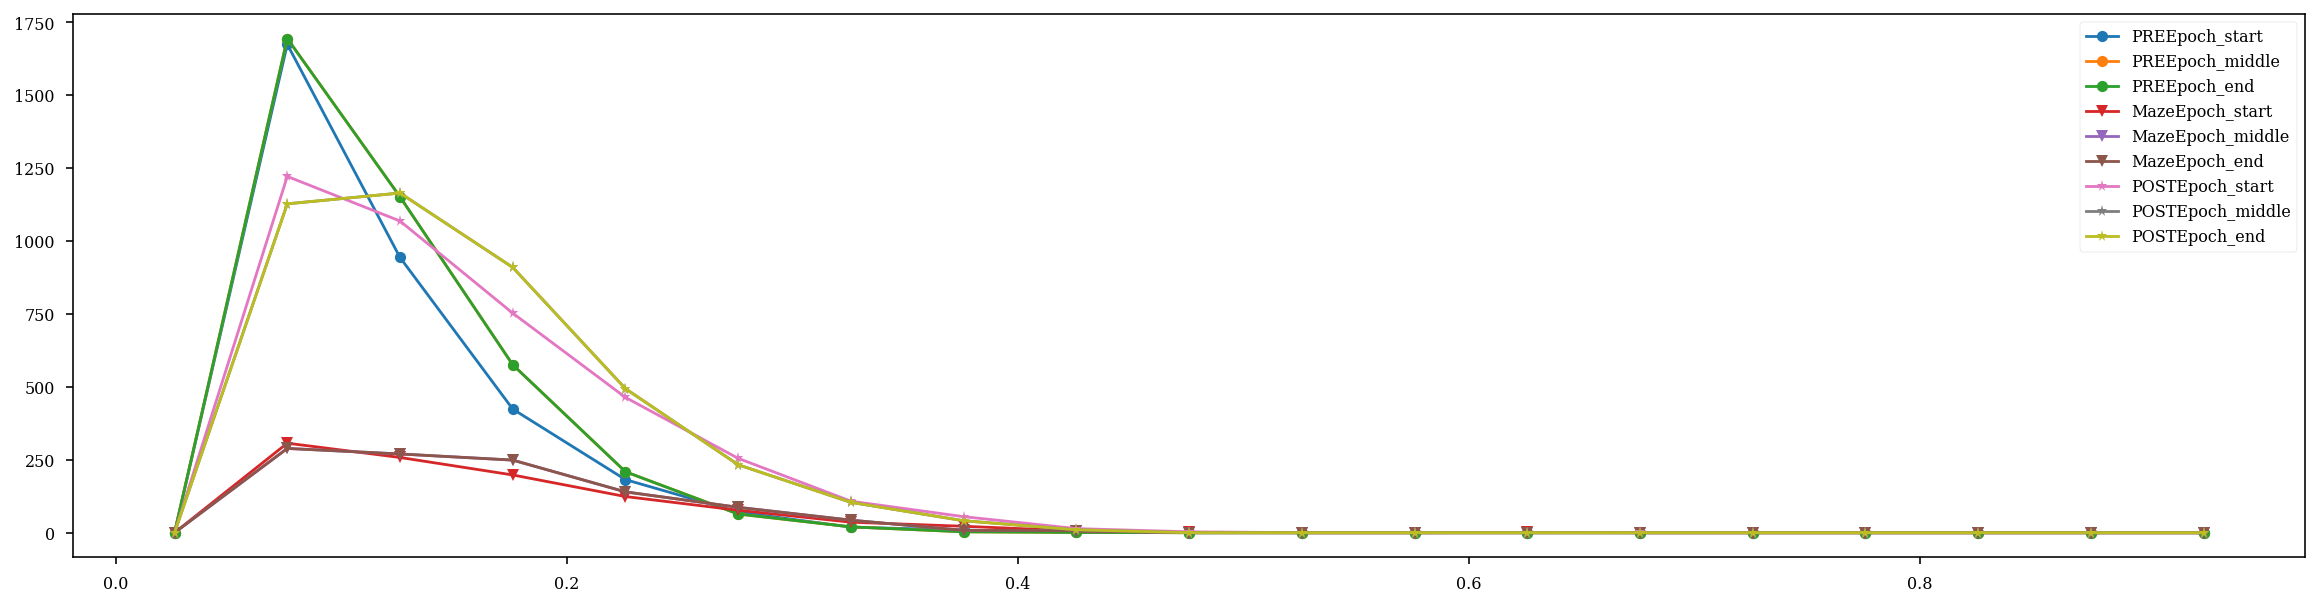

In [159]:
# for basepath in df_grosmark.basepath.unique():
basepath = df_grosmark.basepath.unique()[3]
_,data = loading.load_cell_metrics(basepath)

# bins = np.arange(0,.2,0.005)
bin_width = 0.05
bins = np.arange(0.001,1,bin_width)
bin_centers = bins[0:-1]+bin_width/2

plt.figure(figsize=(20,5))
linestyles = ["-","--",":"]
markers = ["o","v","*"]
for i,ep in enumerate(data["epochs"].itertuples()):
    temp_df = df_grosmark[(df_grosmark.peaks >= ep.startTime) &
                            (df_grosmark.peaks <= ep.stopTime) &
                            (df_grosmark.basepath==basepath)]

    binned,_ = np.histogram(temp_df['sup start'],bins = bins)
    plt.plot(bin_centers,binned,label=ep.name+'_start',marker=markers[i])

    binned,_ = np.histogram(temp_df['sup middle'],bins = bins)
    plt.plot(bin_centers,binned,label=ep.name+'_middle',marker=markers[i])

    binned,_ = np.histogram(temp_df['sup end'],bins = bins)
    plt.plot(bin_centers,binned,label=ep.name+'_end',marker=markers[i])
plt.legend()
# plt.xscale("log")

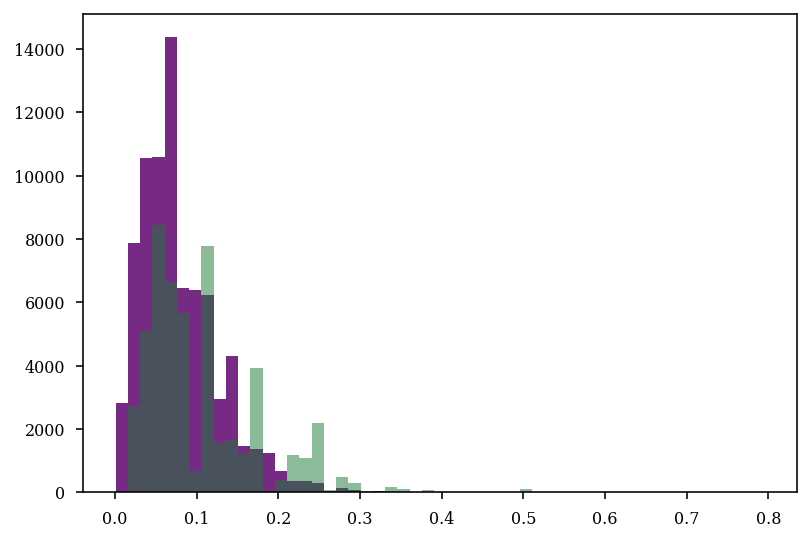

In [286]:
bins = np.arange(0.001,0.8,0.015)

plt.hist(df_grosmark['deep start'],bins = bins)
plt.hist(df_grosmark['sup start'],bins = bins,alpha=.5)

plt.show()

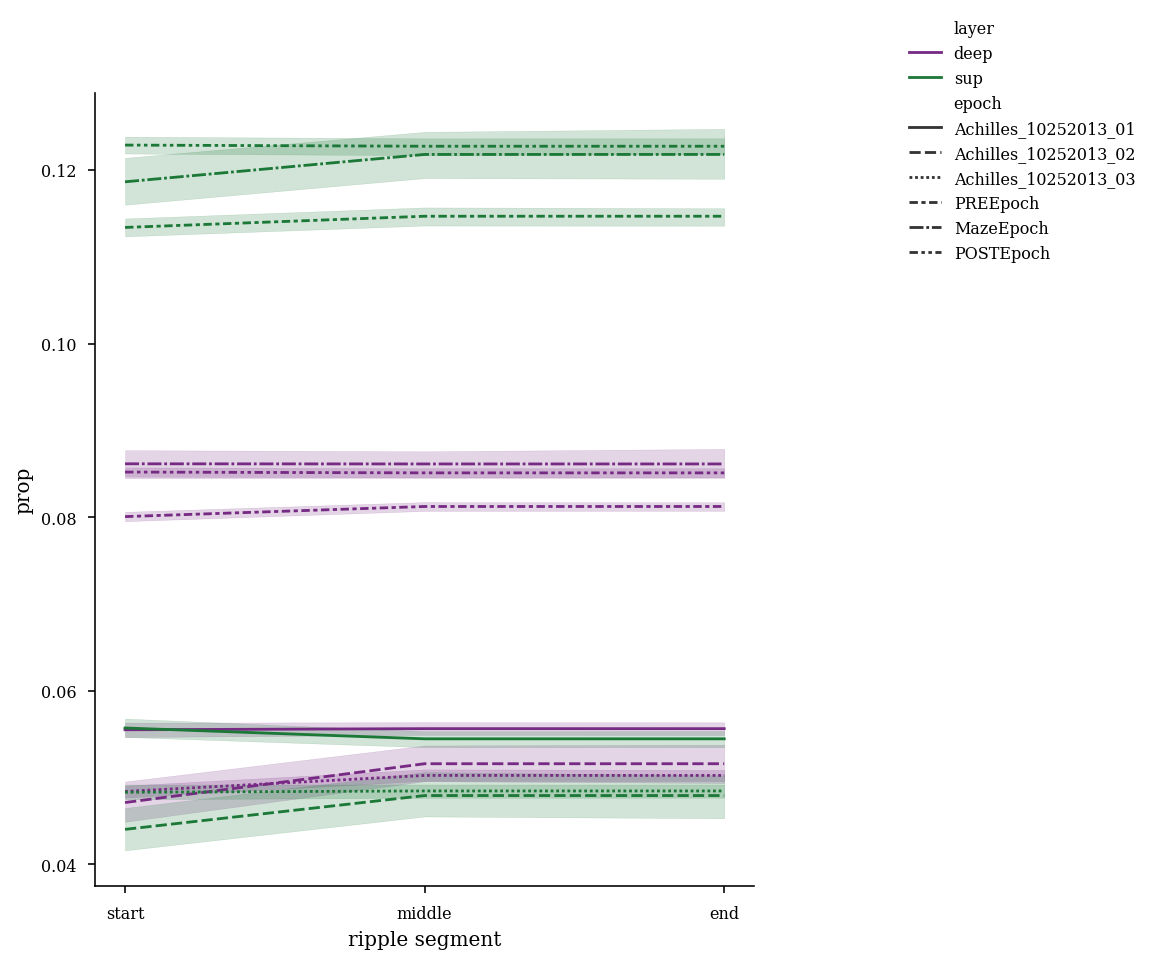

In [284]:
def make_df(temp_df):
    long_temp_df = pd.DataFrame()

    long_temp_df["prop"] = np.hstack([temp_df['deep start'],
                                        temp_df['deep middle'],
                                        temp_df['deep end'],
                                        temp_df['sup start'],
                                        temp_df['sup middle'],
                                        temp_df['sup end']])
    long_temp_df['layer'] = (
                            ["deep"]*len(np.hstack([temp_df['deep start'],
                                        temp_df['deep middle'],
                                        temp_df['deep end']])) +
                            ["sup"]*len(np.hstack([temp_df['sup start'],
                                        temp_df['sup middle'],
                                        temp_df['sup end']]))
                            )
    n = len(temp_df['deep start'])
    long_temp_df['ripple segment'] = (
                                ["start"]*n +
                                ["middle"]*n +
                                ["end"]*n +
                                ["start"]*n +
                                ["middle"]*n +
                                ["end"]*n
                            )
    return long_temp_df

long_temp_df = pd.DataFrame()
for basepath in df_grosmark.basepath.unique():
    # basepath = df_grosmark.basepath.unique()[7]
    _,data = loading.load_cell_metrics(basepath)

    for i,ep in enumerate(data["epochs"].itertuples()):
        temp_df = df_grosmark[(df_grosmark.peaks >= ep.startTime) &
                                (df_grosmark.peaks <= ep.stopTime) &
                                (df_grosmark.basepath==basepath)]
                                
        temp_df = make_df(temp_df) 
        temp_df["epoch"] = ep.name
        temp_df['basepath'] = basepath

        long_temp_df = long_temp_df.append(temp_df,ignore_index=True)

    
# values above zero
idx = long_temp_df.prop.values>0


group_colors = {"deep": '#762a83',
                'sup': '#1b7837',} 
sns.set_palette(sns.color_palette(group_colors.values()))

plt.figure(figsize=functions.set_size('thesis', fraction=1, subplots=(2, 1)), edgecolor='k')
sns.lineplot(x="ripple segment", y="prop",
             hue="layer",style="epoch",
             data=long_temp_df[idx],hue_order=group_colors.keys())

plt.legend(bbox_to_anchor=(1.1, 0.01, 0.5, 1.1),frameon=False)
ax = plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

# plt.ylim(0,.2)

(0.0, 0.3)

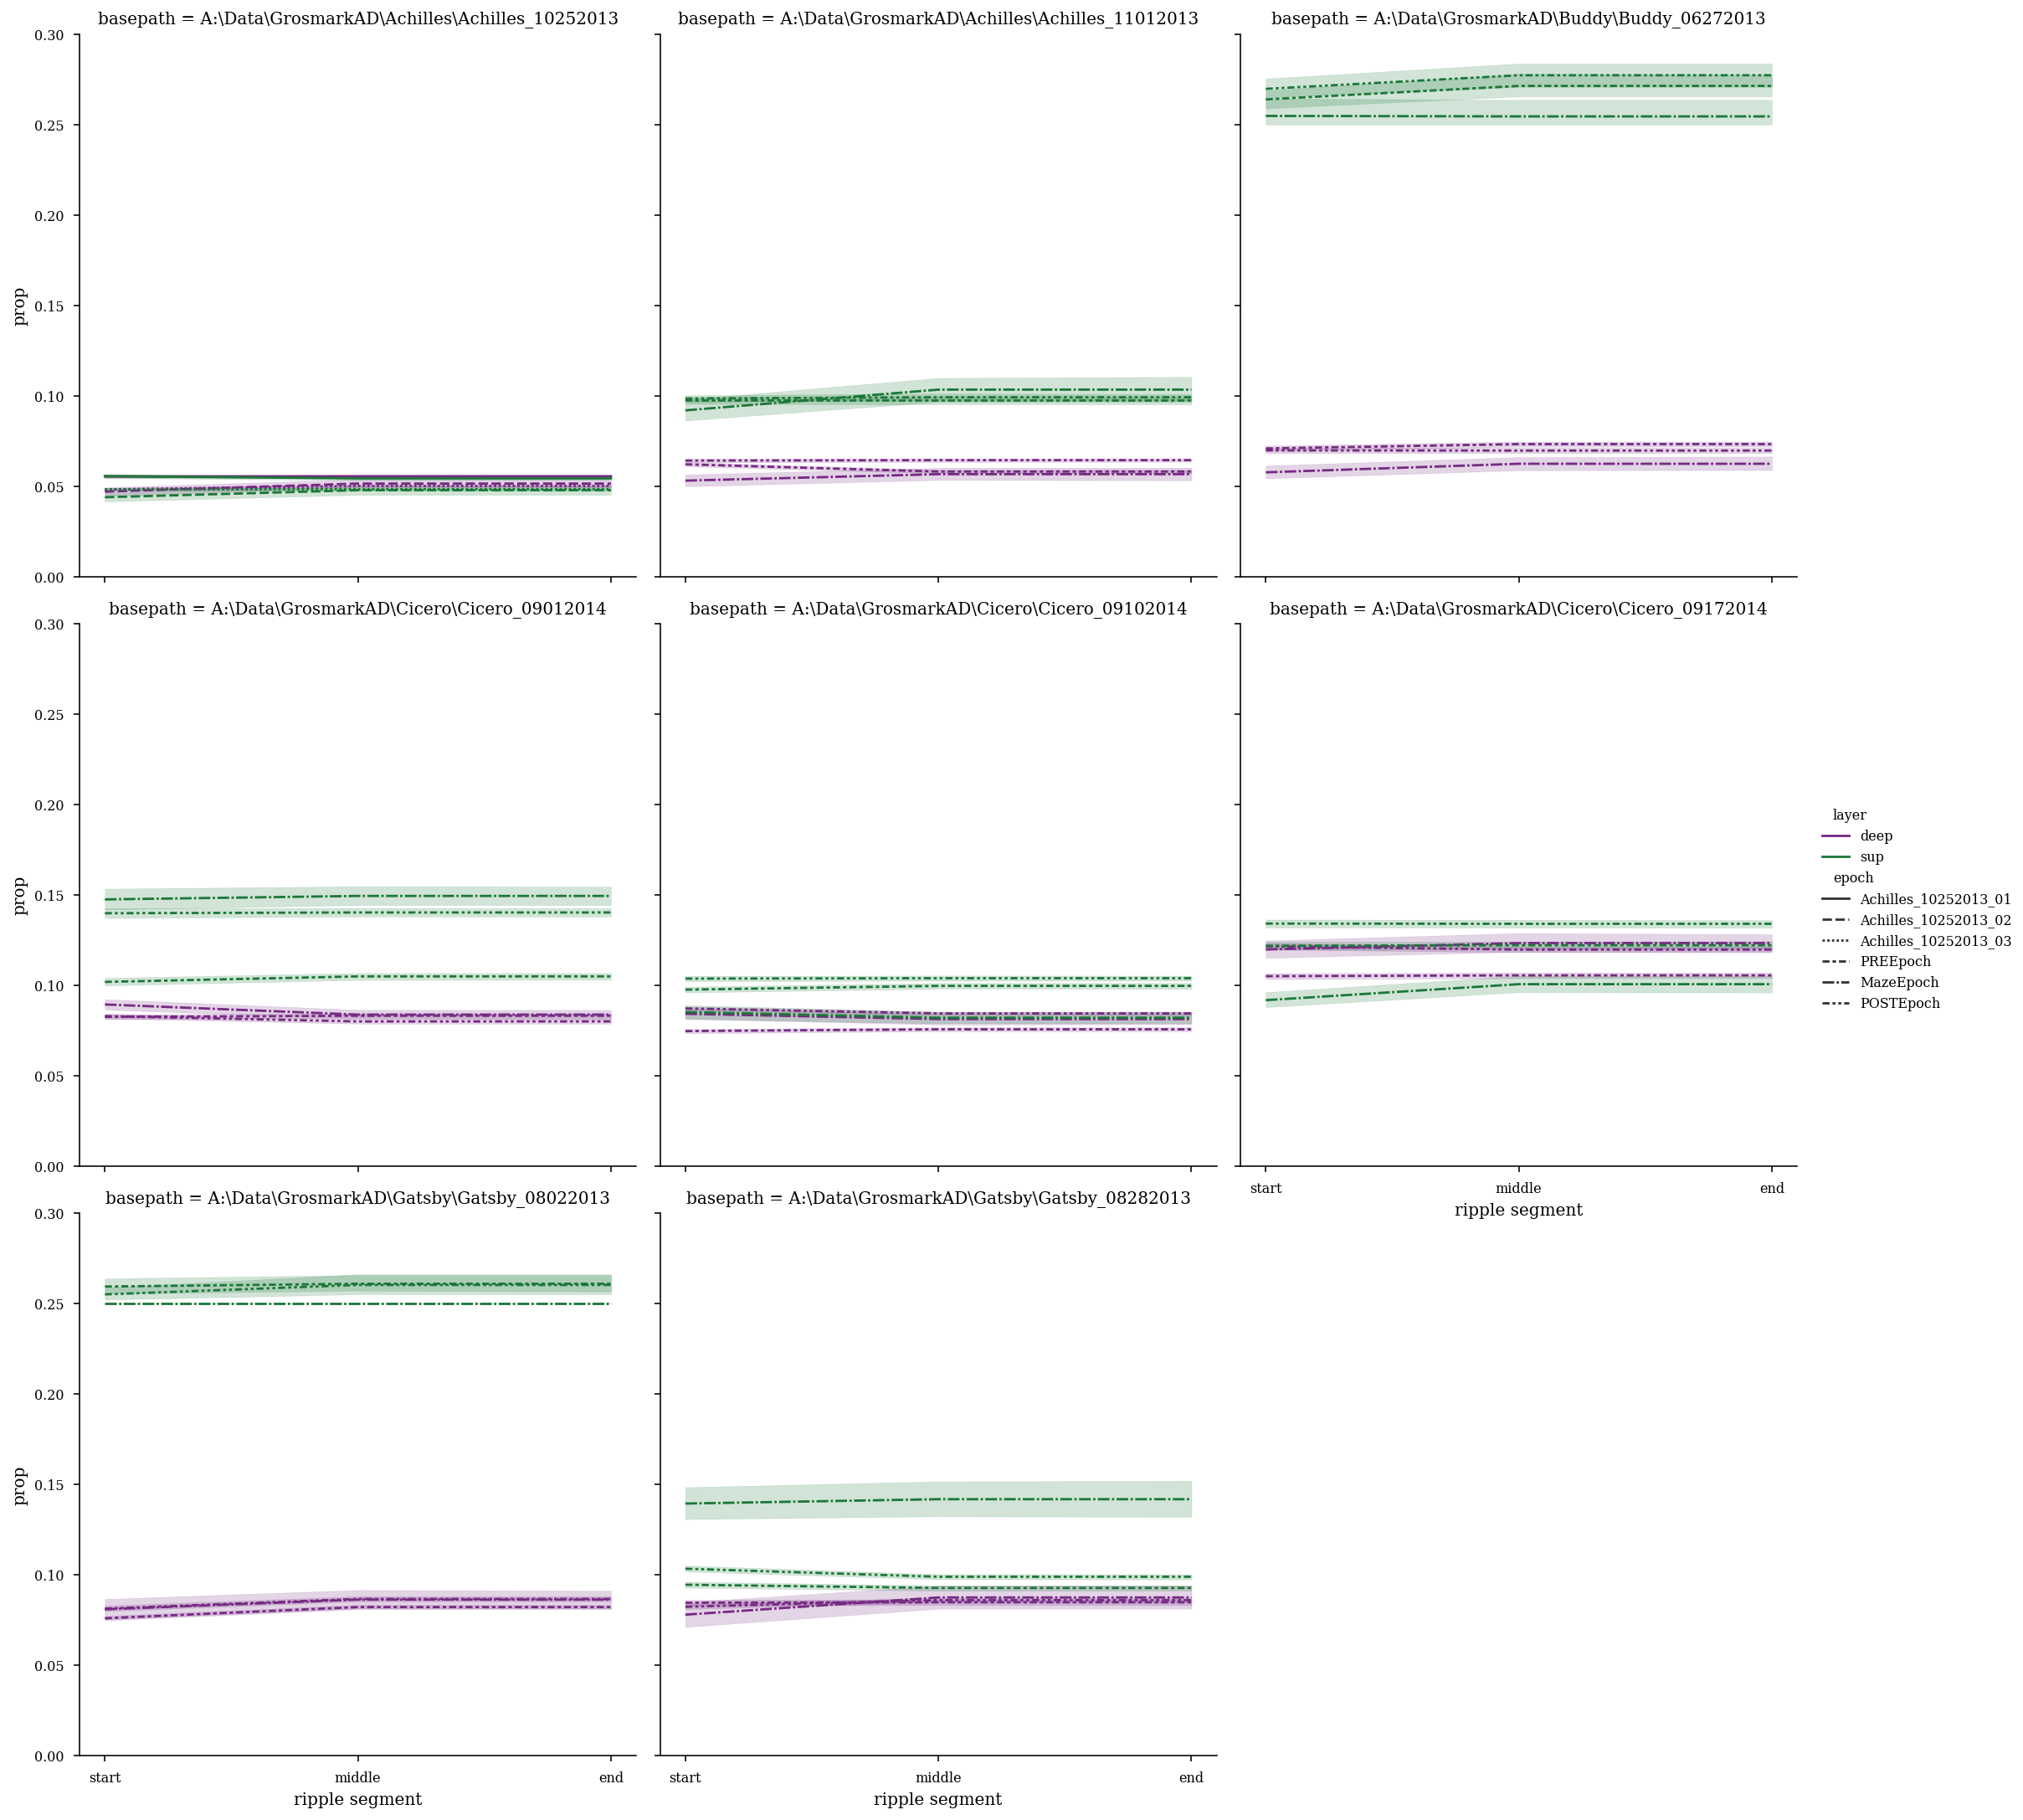

In [285]:
sns.relplot(
    data=long_temp_df[idx], x="ripple segment", y="prop",
    col="basepath", hue="layer", style="epoch",
    kind="line",col_wrap=3
)
plt.ylim(0,0.3)

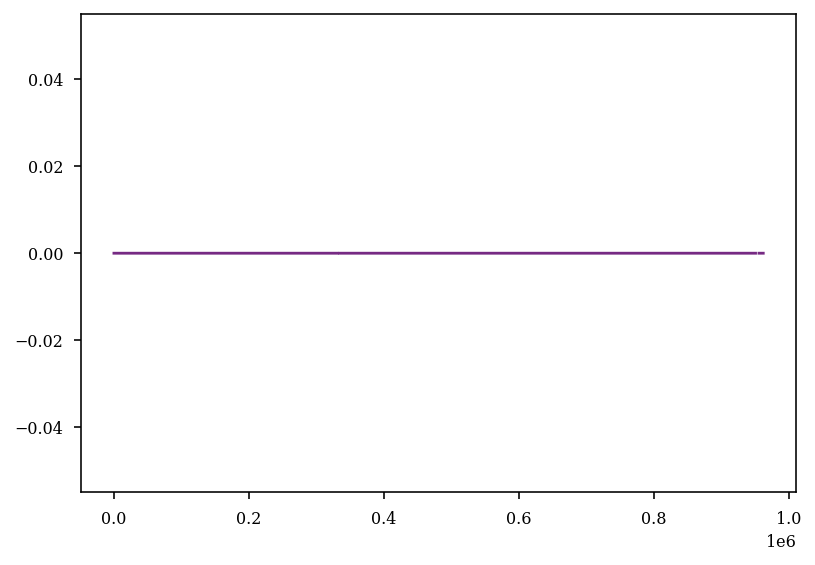

In [307]:
# df_grosmark[['deep start', 'deep middle', 'deep end']][idx][0:100]

plt.plot(results['deep middle'] - results['deep end'])

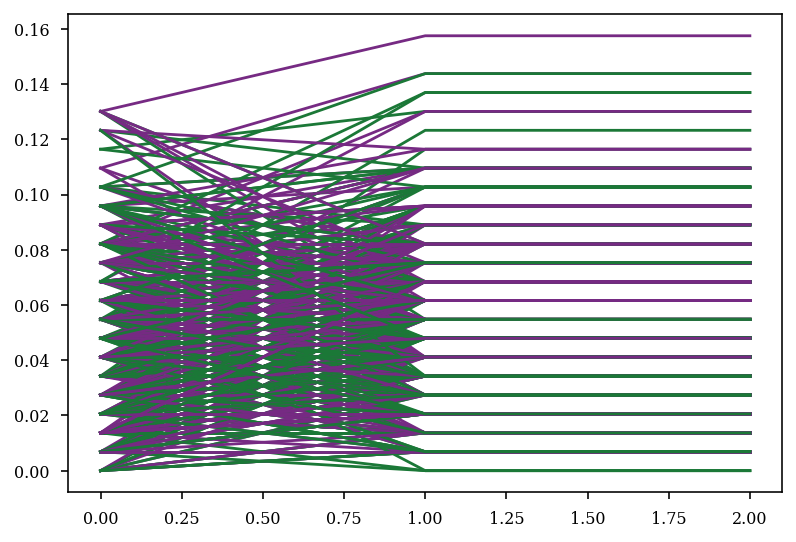

In [304]:
# long_temp_df[(long_temp_df['layer'] == "deep") & (long_temp_df['ripple segment'] == "start")]

df_grosmark.keys()
idx = np.any(df_grosmark[['deep start', 'deep middle', 'deep end','sup start', 'sup middle','sup end']].values > 0,axis=1)
plt.plot(df_grosmark[['deep start', 'deep middle', 'deep end']][idx][0:1000].values.T)
plt.show()


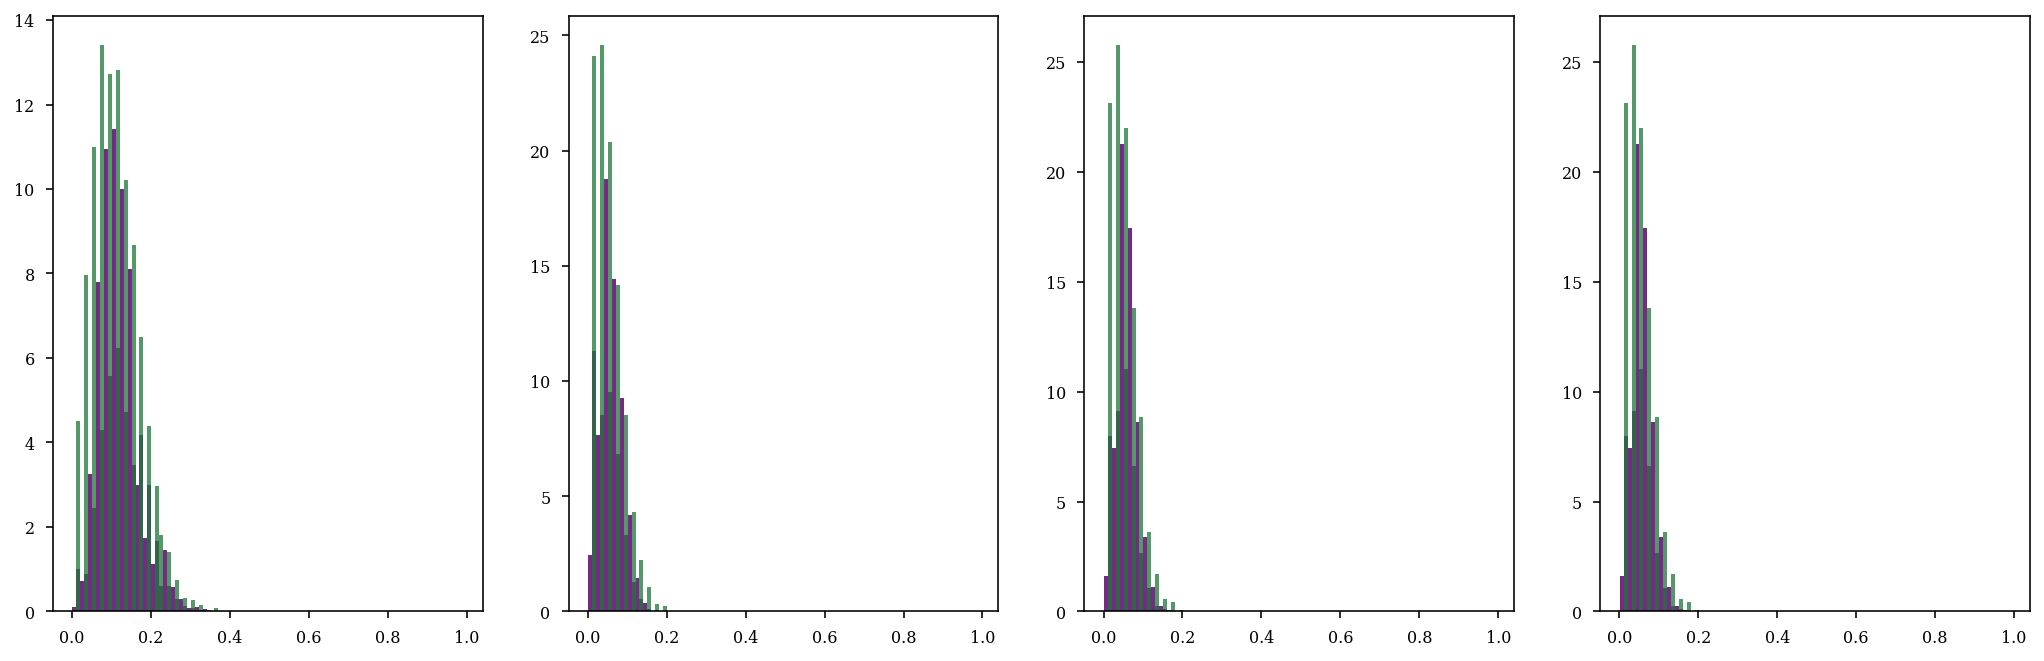

In [85]:
fig, axs = plt.subplots(1,4,figsize=functions.set_size('thesis', fraction=3, subplots=(1, 2)), edgecolor='k')
fig.subplots_adjust(hspace = 0, wspace=0.2)
axs = axs.ravel()

bins = np.arange(0.001,1,0.01)

axs[0].hist(temp_df['deep whole'],bins = bins,density=True,color='#762a83')
axs[0].hist(temp_df['sup whole'],bins = bins,density=True,color='#1b7837',alpha=.75)

axs[1].hist(temp_df['deep start'],bins = bins,density=True,color='#762a83')
axs[1].hist(temp_df['sup start'],bins = bins,density=True,color='#1b7837',alpha=.75)

axs[2].hist(temp_df['deep middle'],bins = bins,density=True,color='#762a83')
axs[2].hist(temp_df['sup middle'],bins = bins,density=True,color='#1b7837',alpha=.75)

axs[3].hist(temp_df['deep end'],bins = bins,density=True,color='#762a83')
axs[3].hist(temp_df['sup end'],bins = bins,density=True,color='#1b7837',alpha=.75)

plt.show()

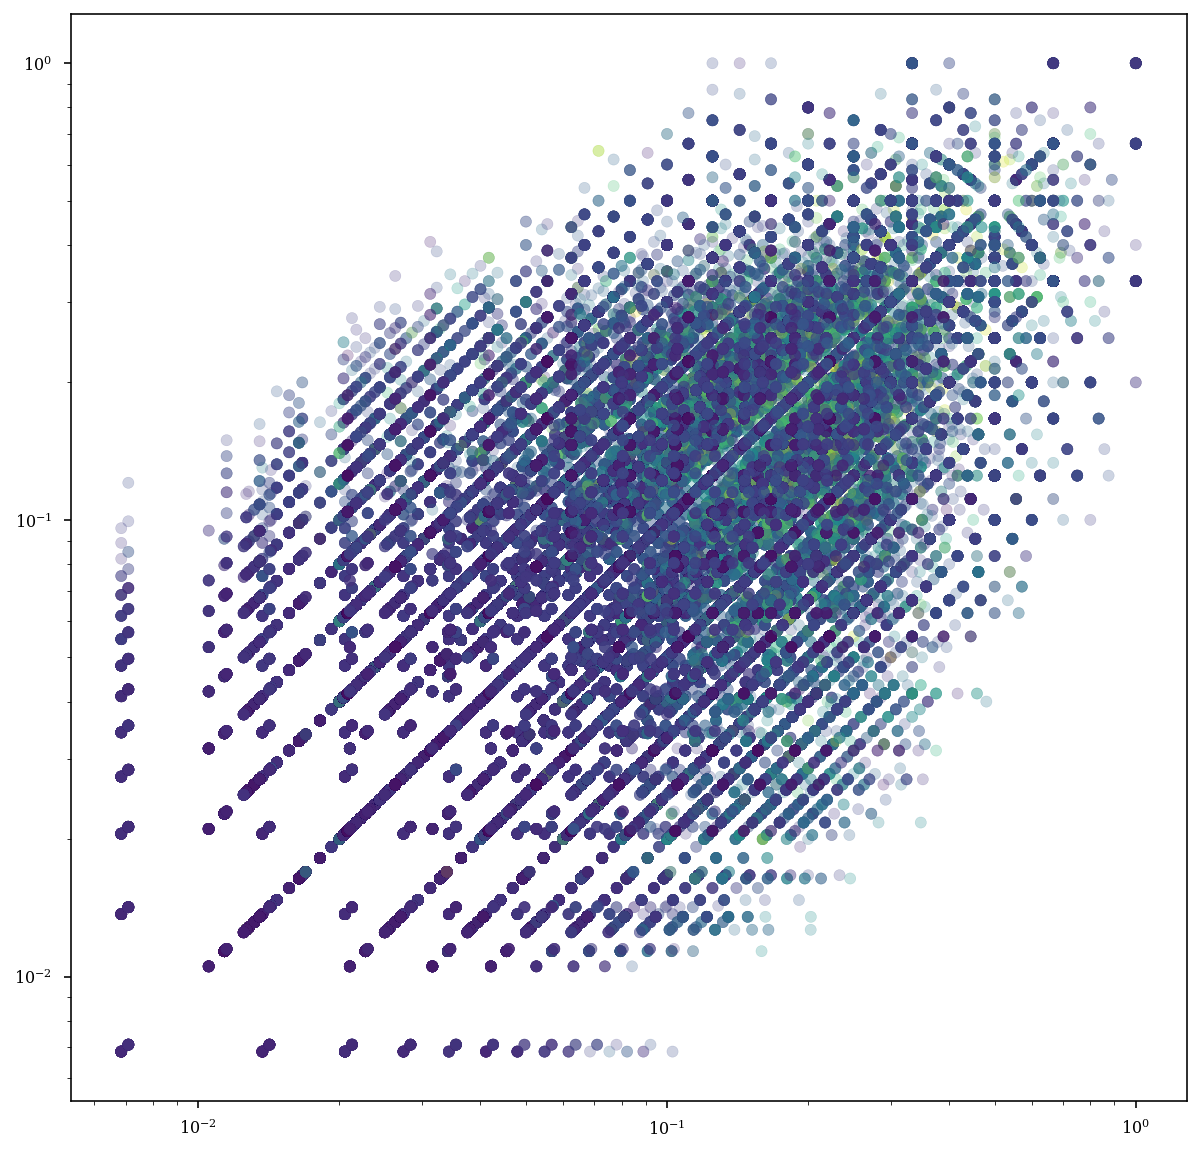

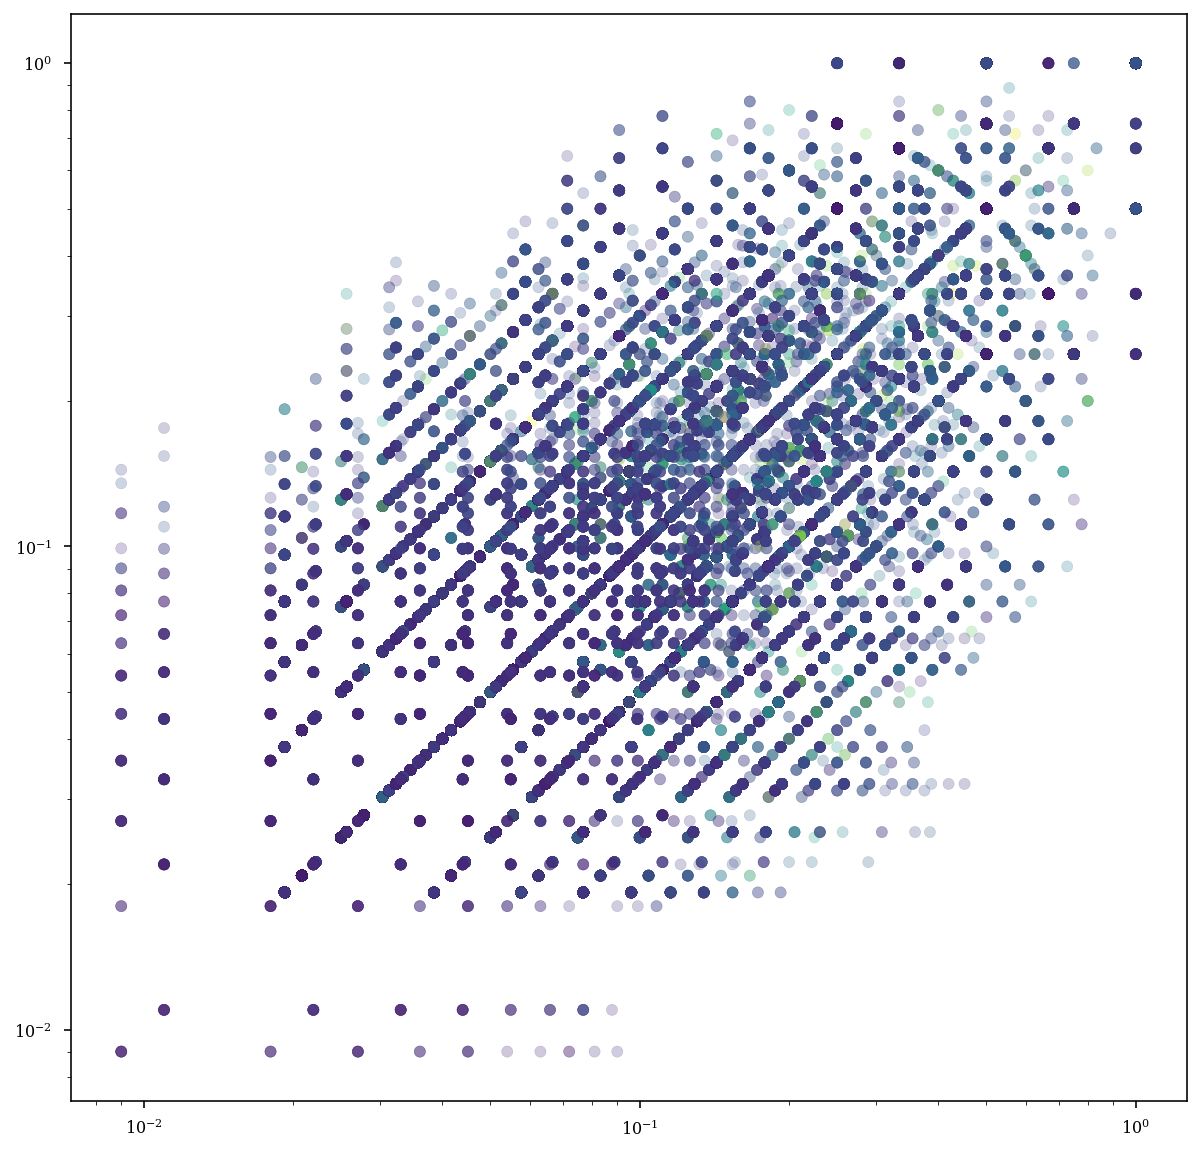

In [40]:
plt.figure(figsize=(10,10))
plt.scatter(results['deep start'],results['deep end'],alpha=.25,c=results.duration)
plt.xscale("log")
plt.yscale("log")

plt.figure(figsize=(10,10))
plt.scatter(results['sup start'],results['sup end'],alpha=.25,c=results.duration)
plt.xscale("log")
plt.yscale("log")

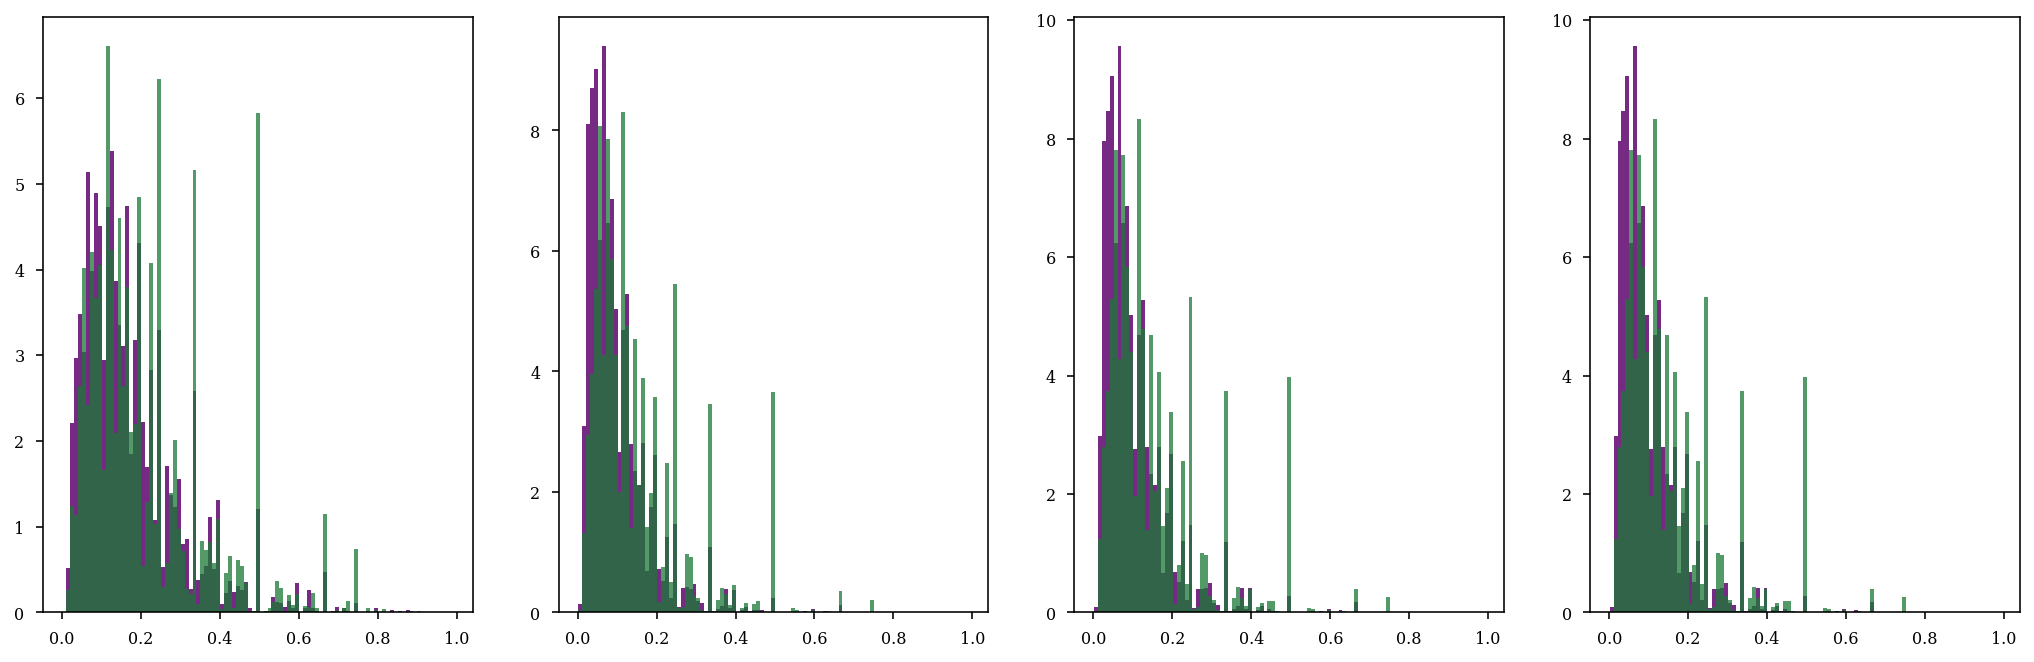

In [66]:
# plt.figure(figsize=(10,10))
bins = np.arange(0.001,1,0.01)
# plt.hist(results['sup start'],bins = bins)
# plt.hist(results['sup middle'],bins = bins,alpha=.5)
# plt.hist(results['sup end'],bins = bins,alpha=.25)

# plt.show()
# plt.scatter(results['deep whole'],results['sup whole'],alpha=.25)

fig, axs = plt.subplots(1,4,figsize=functions.set_size('thesis', fraction=3, subplots=(1, 2)), edgecolor='k')
fig.subplots_adjust(hspace = 0, wspace=0.2)
axs = axs.ravel()

axs[0].hist(results['deep whole'],bins = bins,density=True,color='#762a83')
axs[0].hist(results['sup whole'],bins = bins,density=True,color='#1b7837',alpha=.75)

axs[1].hist(results['deep start'],bins = bins,density=True,color='#762a83')
axs[1].hist(results['sup start'],bins = bins,density=True,color='#1b7837',alpha=.75)

axs[2].hist(results['deep middle'],bins = bins,density=True,color='#762a83')
axs[2].hist(results['sup middle'],bins = bins,density=True,color='#1b7837',alpha=.75)

axs[3].hist(results['deep end'],bins = bins,density=True,color='#762a83')
axs[3].hist(results['sup end'],bins = bins,density=True,color='#1b7837',alpha=.75)

plt.show()



# Testing and examples below

   name  startTime  stopTime
0  task        0.0    6022.4
1  post     6022.4   15169.1


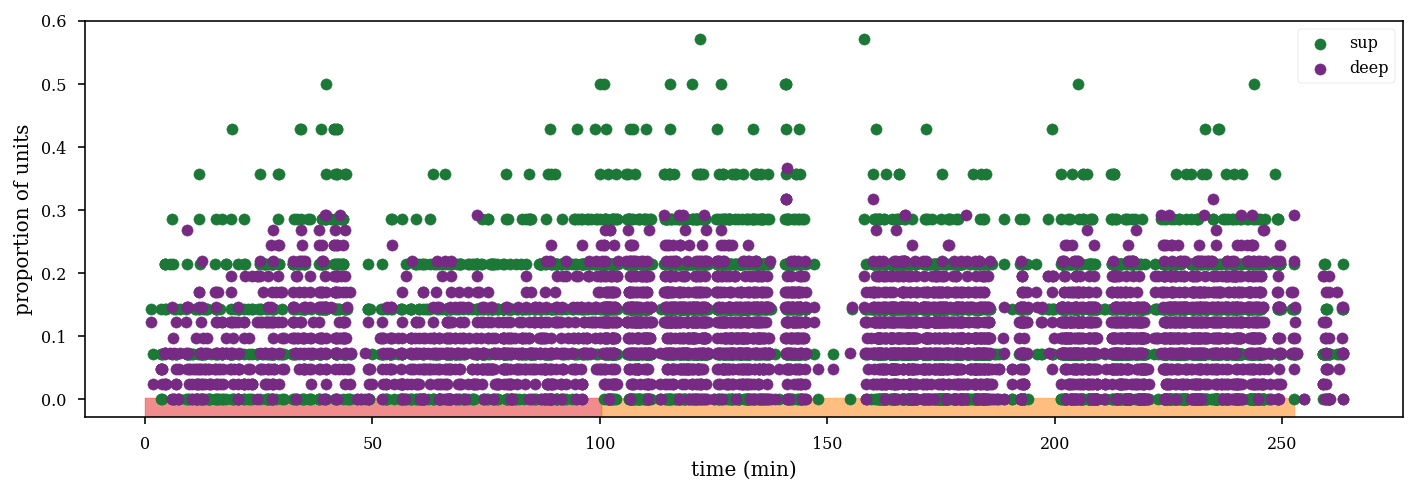

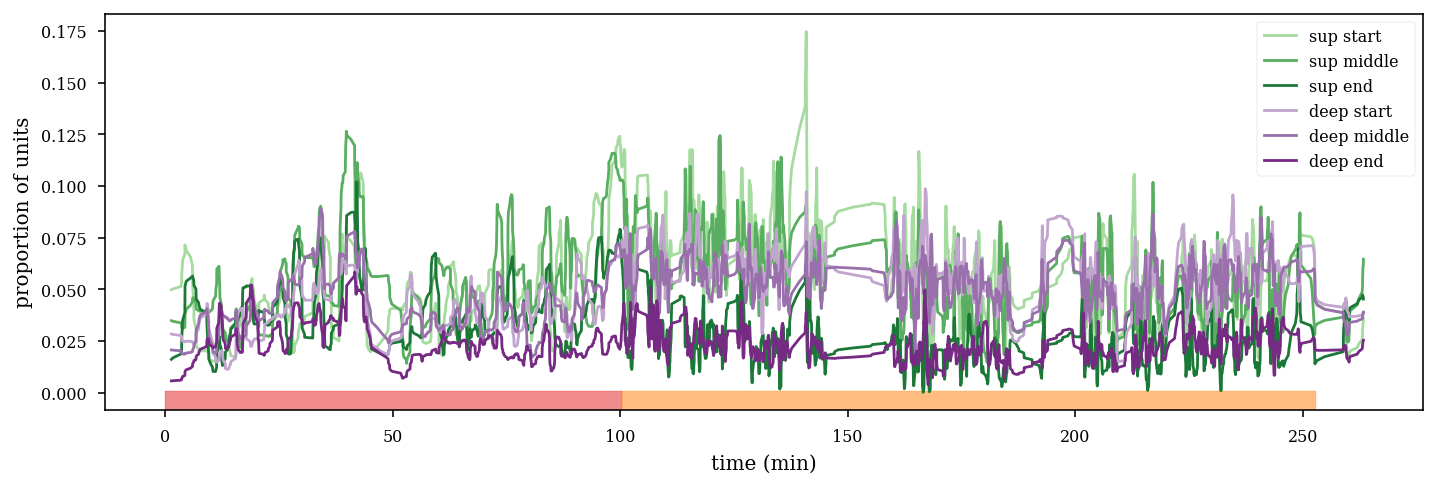

In [163]:
# plt.figure(figsize=(20,4))
# plt.imshow(n_deep,aspect="auto",interpolation="nearest",vmax=.3,vmin=0)
# plt.figure(figsize=(20,4))
# plt.imshow(n_sup,aspect="auto",interpolation="nearest",vmax=.3,vmin=0)
cmap = matplotlib.cm.get_cmap('Set1',data["epochs"].shape[0]+1)

plt.figure(figsize=functions.set_size('thesis', fraction=2, subplots=(1, 2)), edgecolor='k')
plt.scatter(ripples.peaks/60,n_sup_whole_rip[0,:],color='#1b7837',label="sup")
plt.scatter(ripples.peaks/60,n_deep_whole_rip[0,:],color='#762a83',label="deep")
plt.xlabel('time (min)')
plt.ylabel('proportion of units')

for i,epochs in enumerate(data["epochs"].itertuples()):
    plt.axvspan(epochs.startTime/60, epochs.stopTime/60,
                ymin=-.1,ymax=.05, alpha=0.5, color=cmap(i), zorder=-1000)
plt.legend()

plt.figure(figsize=functions.set_size('thesis', fraction=2, subplots=(1, 2)), edgecolor='k')

plt.plot(ripples.peaks/60,gaussian_filter1d(n_sup[0,:], 5),color='#a6dba0',label="sup start")
plt.plot(ripples.peaks/60,gaussian_filter1d(n_sup[1,:], 5),color='#5aae61',label="sup middle")
plt.plot(ripples.peaks/60,gaussian_filter1d(n_sup[2,:], 5),color='#1b7837',label="sup end")

plt.plot(ripples.peaks/60,gaussian_filter1d(n_deep[0,:], 5),color='#c2a5cf',label="deep start")
plt.plot(ripples.peaks/60,gaussian_filter1d(n_deep[1,:], 5),color='#9970ab',label="deep middle")
plt.plot(ripples.peaks/60,gaussian_filter1d(n_deep[2,:], 5),color='#762a83',label="deep end")

for i,epochs in enumerate(data["epochs"].itertuples()):
    plt.axvspan(epochs.startTime/60, epochs.stopTime/60,
                ymin=-.1,ymax=.05, alpha=0.5, color=cmap(i), zorder=-1000)
    # plt.axvline(epochs.startTime/60,color="k",zorder=-1000)
plt.xlabel('time (min)')
plt.ylabel('proportion of units')

plt.legend()
fig_save_path = 'G:/My Drive/post_doc/ripple_diversity/project_log'
print(data["epochs"])
plt.savefig(os.path.join(fig_save_path,'ripple_segment_participation_example.pdf'),dpi=300,bbox_inches='tight')
# plt.savefig(os.path.join(fig_save_path,'ripple_segment_participation_example.png'),dpi=300,bbox_inches='tight')


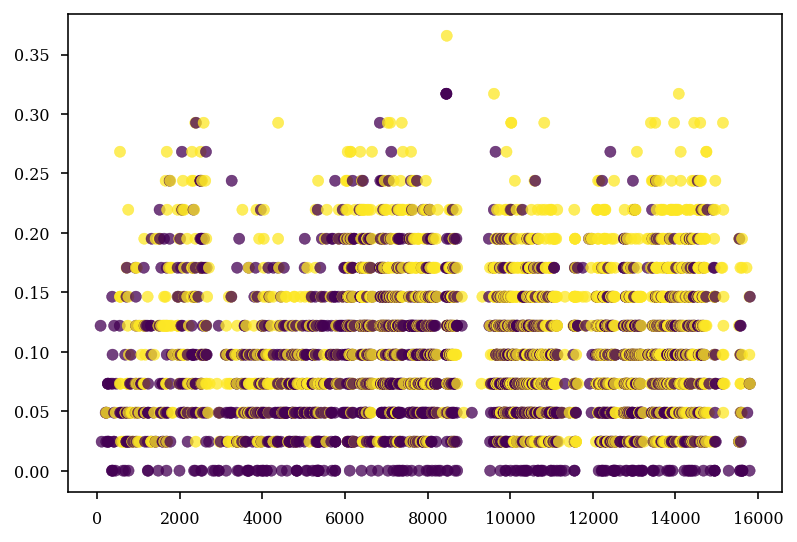

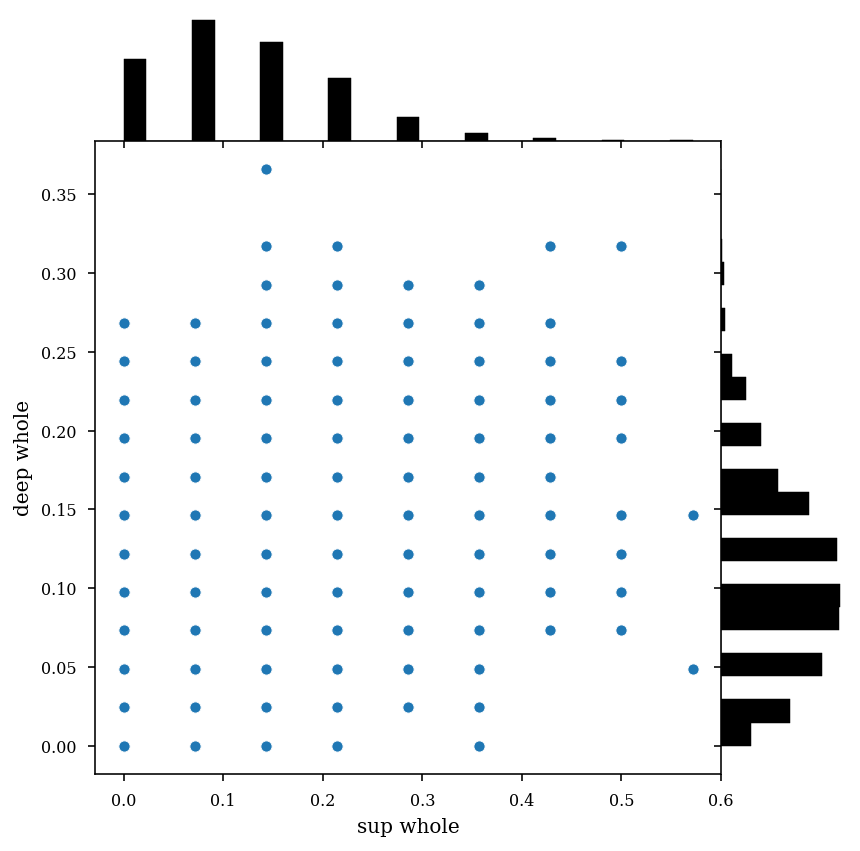

In [145]:
plt.scatter(ripples.peaks,n_deep_whole_rip[0,:],c=deep_dom,alpha=.75)
plt.show()

# plt.scatter(ripples.peaks,n_sup_whole_rip[0,:],c=ripples.duration,alpha=.75)
# plt.show()

g = sns.JointGrid(data=session_df, x="sup whole", y="deep whole", space=0)
g.plot_joint(sns.scatterplot,cmap="rocket")
g.plot_marginals(sns.histplot, color="k", alpha=1, bins=25)

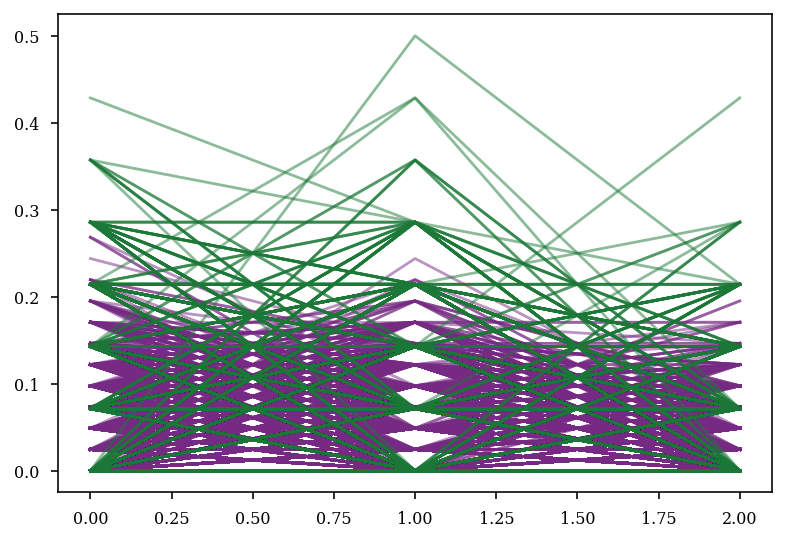

In [162]:
plt.plot(n_deep,color='#762a83',alpha=.5)
plt.plot(n_sup,color='#1b7837',alpha=.5)

plt.show()

In [165]:
sum(cell_metrics.deepSuperficial == "Superficial") / cell_metrics.shape[0]
sum(cell_metrics.deepSuperficial == "Deep") / cell_metrics.shape[0]


0.7454545454545455

In [169]:
n_deep_whole_rip[0,:]

array([0.12195122, 0.02439024, 0.04878049, ..., 0.07317073, 0.07317073,
       0.14634146])

In [182]:
print(n_deep_whole_rip[0,:])
n_deep_whole_rip[0,:] / sum(cell_metrics.deepSuperficial == "Deep")

[0.12195122 0.02439024 0.04878049 ... 0.07317073 0.07317073 0.14634146]


array([0.00297442, 0.00059488, 0.00118977, ..., 0.00178465, 0.00178465,
       0.0035693 ])

In [181]:
print(n_sup_whole_rip[0,:])
n_sup_whole_rip[0,:] / sum(cell_metrics.deepSuperficial == "Superficial")

[0.14285714 0.07142857 0.14285714 ... 0.14285714 0.07142857 0.21428571]


array([0.01020408, 0.00510204, 0.01020408, ..., 0.01020408, 0.00510204,
       0.01530612])

<AxesSubplot:>

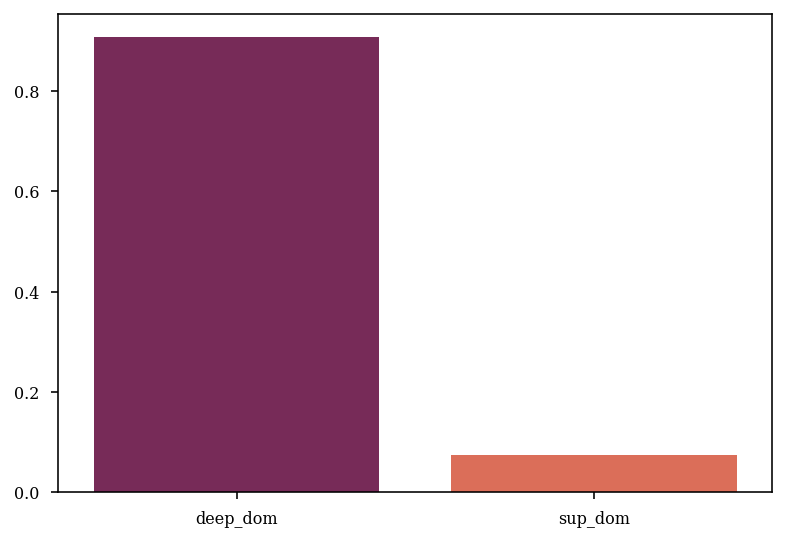

In [190]:
deep_dom = n_deep_whole_rip[0,:] * (sum(cell_metrics.deepSuperficial == "Deep")/cell_metrics.shape[0]) > n_sup_whole_rip[0,:] * (sum(cell_metrics.deepSuperficial == "Superficial")/cell_metrics.shape[0])
sup_dom = n_deep_whole_rip[0,:] * (sum(cell_metrics.deepSuperficial == "Deep")/cell_metrics.shape[0]) < n_sup_whole_rip[0,:] * (sum(cell_metrics.deepSuperficial == "Superficial")/cell_metrics.shape[0])

sns.barplot(x=['deep_dom','sup_dom'], y=[deep_dom.sum()/len(deep_dom),sup_dom.sum()/len(deep_dom)], palette="rocket")

In [156]:
deep_dom = n_deep_whole_rip[0,:] > n_sup_whole_rip[0,:]
sup_dom = n_deep_whole_rip[0,:] < n_sup_whole_rip[0,:]

equal_dom = n_deep_whole_rip[0,:] == n_sup_whole_rip[0,:]

np.where(sup_dom)[0][0:10]
# np.where(deep_dom)[0]


array([ 0,  1,  2,  3,  5,  6,  8,  9, 10, 11], dtype=int64)

In [140]:
session_df = pd.DataFrame()
session_df['duration'] = ripples.duration
session_df['peaks'] = ripples.peaks

session_df['deep whole'] = n_deep_whole_rip[0,:]
session_df['sup whole'] = n_sup_whole_rip[0,:]

session_df['deep start'] = n_deep[0,:]
session_df['deep middle'] = n_deep[1,:]
session_df['deep end'] = n_deep[1,:]
session_df['sup start'] = n_sup[0,:]
session_df['sup middle'] = n_sup[1,:]
session_df['sup end'] = n_sup[1,:]

# sns.histplot(data=session_df,stat="density",cumulative=True,element="step", fill=False)
# sns.histplot(data=session_df, element="step", fill=False,stat="density",common_bins=False,kde=True)


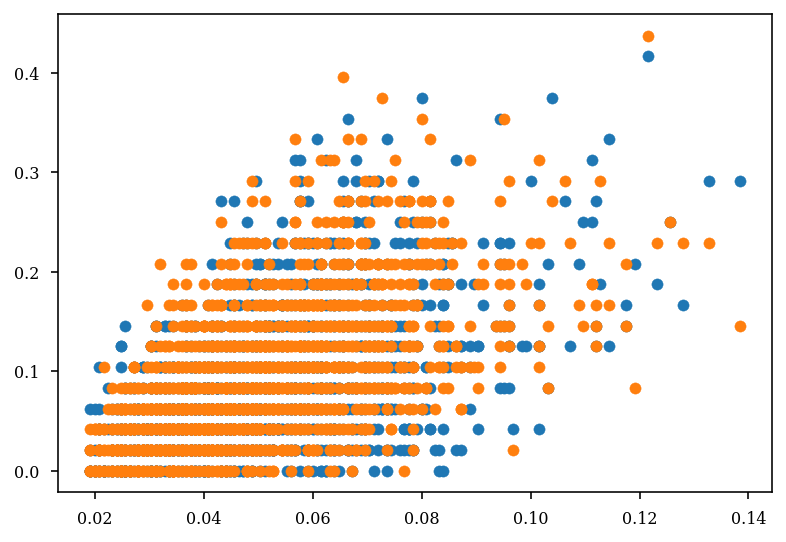

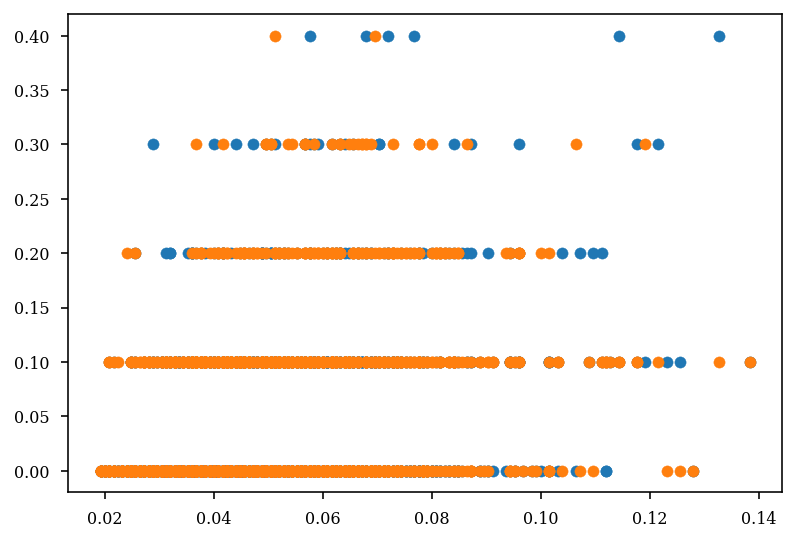

In [90]:
plt.scatter(ripples.duration,session_df['deep start'])
# plt.scatter(ripples.duration,session_df['deep middle'])
# plt.scatter(ripples.duration,session_df['deep end'])

plt.figure()
plt.scatter(ripples.duration,session_df['sup start'])
plt.scatter(ripples.duration,session_df['sup middle'])
# plt.scatter(ripples.duration,session_df['sup end'])

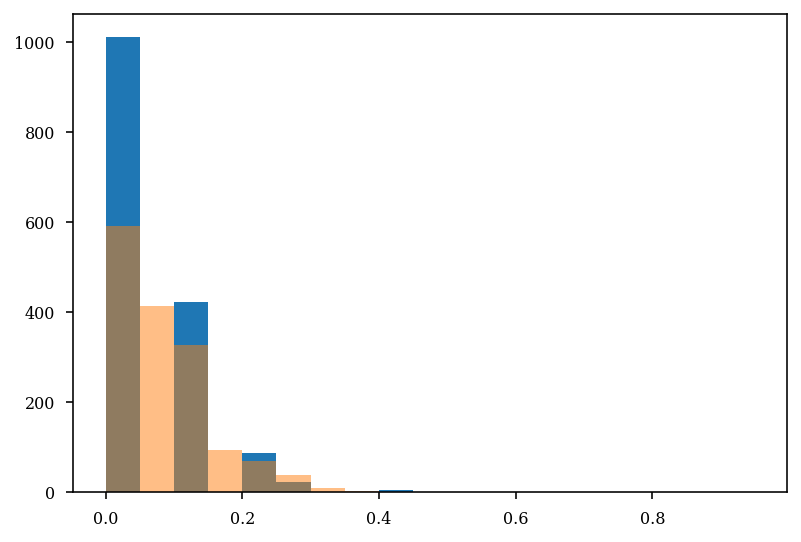

In [55]:
# plt.scatter(n_deep[2,:],n_sup[2,:])
bins = np.arange(0,1,.05)
plt.hist(n_sup[0,:],bins=bins)
plt.hist(n_deep[0,:],bins=bins,alpha=.5)

plt.show()

In [46]:
ts_epoch = []
for rip_i in range(ripple_epochs.n_intervals):
    ts = np.linspace(ripple_epochs[rip_i].starts,ripple_epochs[rip_i].stops,4)
    ts_epoch.append([ts[0],ts[1]])
    ts_epoch.append([ts[1],ts[2]])
    ts_epoch.append([ts[2],ts[3]])

ripple_seg_epochs = nel.EpochArray(np.hstack(ts_epoch).T)
st_rip_seg = st[ripple_seg_epochs]

# n_deep = []
# n_sup = []

def main_loop(rip_i,st_rip_seg,cell_metrics):
    active = [unit.shape[0]>0 for unit in st_rip_seg[rip_i].data]

    return sum(cell_metrics.deepSuperficial[active] == "Deep"), sum(cell_metrics.deepSuperficial[active] == "Superficial")

# for i in tqdm(range(st_rip_seg.n_intervals)):
#     active = [unit.shape[0]>0 for unit in st_rip_seg[i].data]
#     n_deep.append(sum(cell_metrics.deepSuperficial[active] == "Deep"))
#     n_sup.append(sum(cell_metrics.deepSuperficial[active] == "Superficial"))


num_cores = multiprocessing.cpu_count()  
results = Parallel(n_jobs=num_cores)(delayed(main_loop)(rip_i,st_rip_seg,cell_metrics) for rip_i in tqdm(range(st_rip_seg.n_intervals)))    


0it [00:00, ?it/s]


TypeError: 'PrettyInt' object is not iterable

In [55]:
def get_participation(st,ripple_epochs):
    # get participation prob.
    # make matrix n rows (units) by n cols (ripple epochs)
    # 1 for at least 1 spike, 0 otherwise
    unit_mat = np.zeros((st.n_units,ripple_epochs.n_intervals))
    for i,event in enumerate(st):
        unit_mat[:,i] = (event.n_events > 0)*1 
        # unit_mat[:,i] = event.n_events/ripple_epochs[i].length
    return unit_mat

unit_mat = get_participation(st_rip_seg,ripple_seg_epochs)


SystemError: <built-in method __deepcopy__ of numpy.ndarray object at 0x000001E1FC8DEF30> returned a result with an error set

100%|██████████| 31341/31341 [15:18<00:00, 34.13it/s]


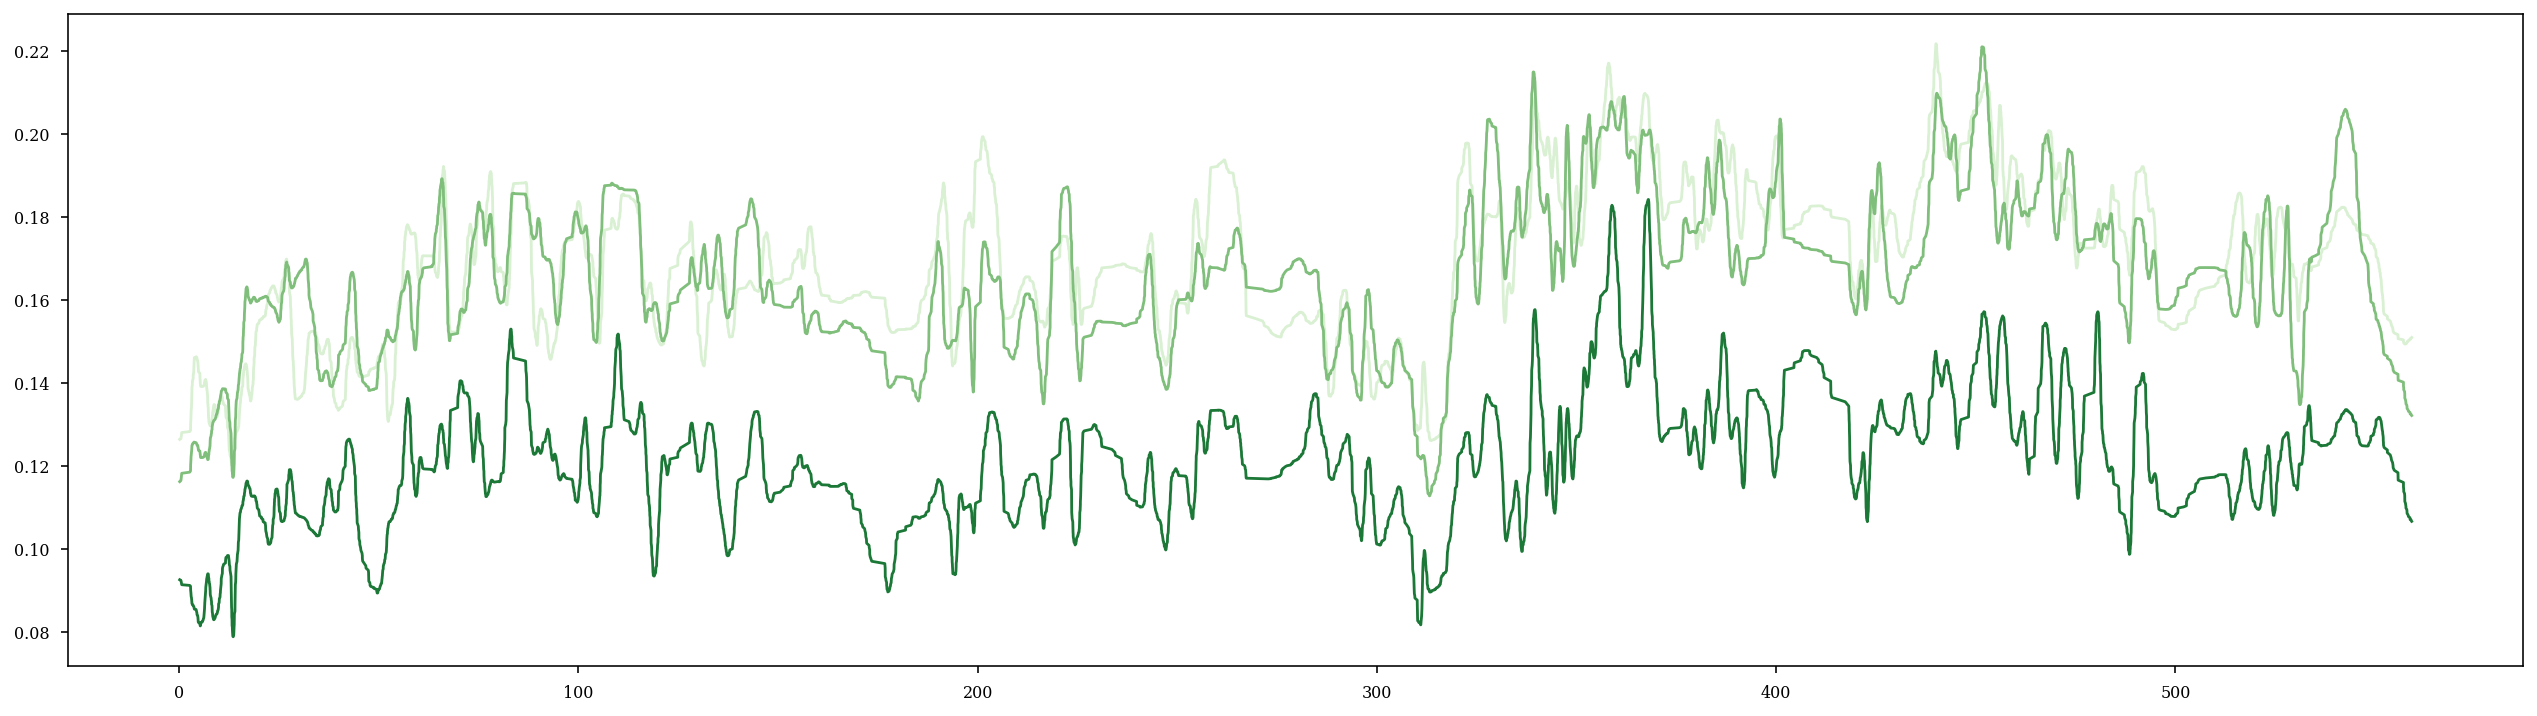

In [43]:
x = np.array(n_sup)
x = x.reshape(int(x.shape[0]/3),3)
x = x/sum(cell_metrics.deepSuperficial== "Superficial")
# plt.plot(x[:,1])

plt.figure(figsize=(22,6))
plt.plot(ripples.peaks/60,gaussian_filter1d(x[:,0], 20),color='#d9f0d3',label="sup start")
plt.plot(ripples.peaks/60,gaussian_filter1d(x[:,1], 20),color='#7fbf7b',label="sup middle")
plt.plot(ripples.peaks/60,gaussian_filter1d(x[:,2], 20),color='#1b7837',label="sup end")
plt.show()


In [168]:
import warnings
warnings.filterwarnings("ignore")
# parallel processing
import multiprocessing
from joblib import Parallel, delayed

def main_loop(rip_i,ripple_epochs,st_rip,cell_metrics,n_deep,n_sup,n_deep_whole_rip,n_sup_whole_rip):

    active = [unit.shape[0]>0 for unit in st_rip[rip_i].data]
    n_deep_whole_rip.append(sum(cell_metrics.deepSuperficial[active] == "Deep"))
    n_sup_whole_rip.append(sum(cell_metrics.deepSuperficial[active] == "Superficial"))

    ts = np.linspace(ripple_epochs[rip_i].starts,ripple_epochs[rip_i].stops,4)
    within_ripple_epochs = nel.EpochArray(np.array([[ts[0],ts[1]],[ts[1],ts[2]],[ts[2],ts[3]]]))
    for rip_inter in range(3):
        active = [unit.shape[0]>0 for unit in st_rip[rip_i][within_ripple_epochs][rip_inter].data]
        n_deep.append(sum(cell_metrics.deepSuperficial[active] == "Deep"))
        n_sup.append(sum(cell_metrics.deepSuperficial[active] == "Superficial"))

    return n_deep,n_sup,n_deep_whole_rip,n_sup_whole_rip

n_deep = []
n_sup = []
n_deep_whole_rip = []
n_sup_whole_rip = []

parallel = 1

# if parallel==1:
num_cores = multiprocessing.cpu_count()  
results = Parallel(n_jobs=num_cores)(delayed(main_loop)(rip_i,
                                                            ripple_epochs,
                                                            st_rip,
                                                            cell_metrics,
                                                            n_deep,
                                                            n_sup,
                                                            n_deep_whole_rip,
                                                            n_sup_whole_rip) for rip_i in tqdm(range(20)))
n_deep,n_sup,n_deep_whole_rip,n_sup_whole_rip
# else:
#     for session in sessions:
#         sys.stdout.write('\rcurrent cell: %s' %(session))
#         sys.stdout.flush()
#         print(session)
#         main_loop(session,data_path,save_path)

# normalize by n units
# n_deep = n_deep/sum(cell_metrics.deepSuperficial == "Deep")
# n_sup = n_sup/sum(cell_metrics.deepSuperficial == "Superficial")
# n_deep_whole_rip = n_deep_whole_rip/sum(cell_metrics.deepSuperficial == "Deep")
# n_sup_whole_rip = n_sup_whole_rip/sum(cell_metrics.deepSuperficial == "Superficial")


100%|██████████| 20/20 [00:00<00:00, 6686.81it/s]


([], [], [], [])

In [186]:
n_deep = np.zeros([3,ripple_epochs.n_intervals])
n_sup = np.zeros_like(n_deep)
n_deep_whole_rip = np.zeros([1,ripple_epochs.n_intervals])
n_sup_whole_rip = np.zeros_like(n_deep_whole_rip)

for i,rip_1 in enumerate(results):
    n_deep[:,i],n_sup[:,i],n_deep_whole_rip[0,i],n_sup_whole_rip[0,i] = rip_1

ValueError: setting an array element with a sequence.

C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:996: UserWarning: ignoring events outside of eventarray support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:996: UserWarning: ignoring events outside of eventarray support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:996: UserWarning: ignoring events outside of eventarray support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:996: UserWarning: ignoring events outside of eventarray support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:996: UserWarning: ignoring events outside of eventarray support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:996: UserWarning: ignoring events outside of eventarray support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-

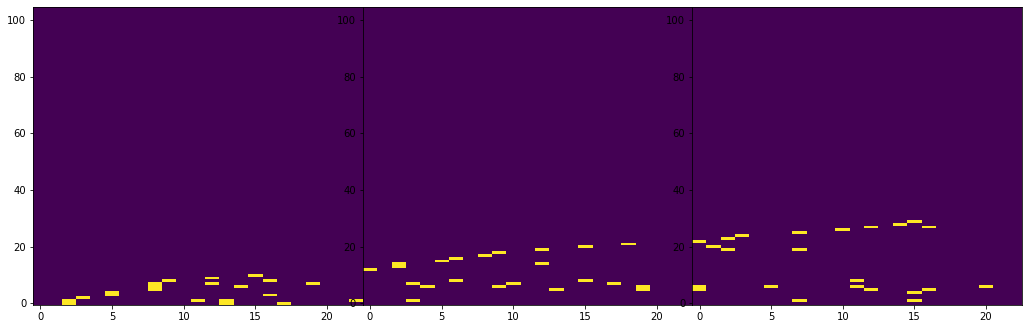

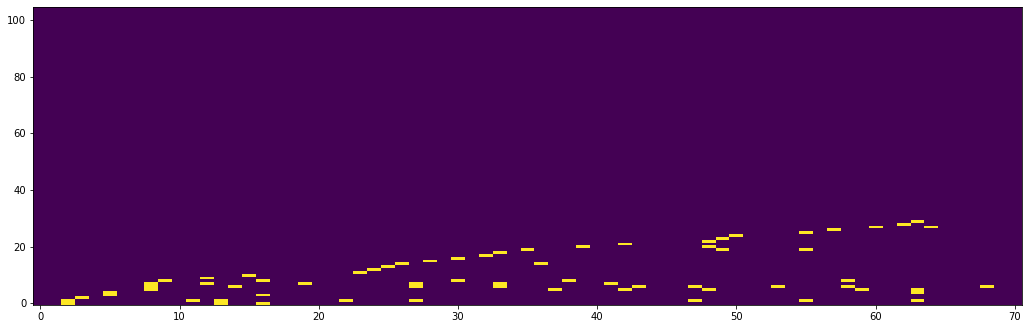

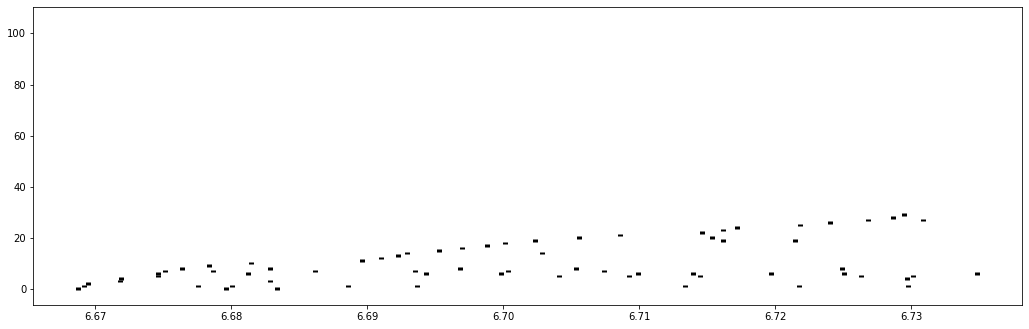

In [107]:
fr_order = np.array(st_rip[0].get_event_firing_order()) - 1

fig, axs = plt.subplots(1,3,figsize=functions.set_size('thesis', fraction=3, subplots=(1, 2)), edgecolor='k')
fig.subplots_adjust(hspace = 0, wspace=0)
axs = axs.ravel()

binnedst = st_rip[0][within_ripple_epochs][0].bin(ds=0.001)
axs[0].imshow(binnedst.data[fr_order,:],interpolation="nearest",aspect="auto",origin="lower")

# plt.figure()
binnedst = st_rip[0][within_ripple_epochs][1].bin(ds=0.001)
axs[1].imshow(binnedst.data[fr_order,:],interpolation="nearest",aspect="auto",origin="lower")

binnedst = st_rip[0][within_ripple_epochs][2].bin(ds=0.001)
axs[2].imshow(binnedst.data[fr_order,:],interpolation="nearest",aspect="auto",origin="lower")


plt.figure(figsize=functions.set_size('thesis', fraction=3, subplots=(1, 2)))
binnedst = st_rip[0].bin(ds=0.001)
plt.imshow(binnedst.data[fr_order,:],interpolation="nearest",aspect="auto",origin="lower")

plt.figure(figsize=functions.set_size('thesis', fraction=3, subplots=(1, 2)))
plt.eventplot(st_rip[0].data[fr_order],color="k",linewidths=5)
plt.show()
